# 시카고 범죄율을 예측해 보자 ( Facebook 의 Prophet 라이브러리 활용 )





# STEP #0: PROBLEM STATEMENT

- The Chicago Crime dataset : 2001 ~ 2017. 
- Datasource: 캐글 https://www.kaggle.com/currie32/crimes-in-chicago
- Dataset contains the following columns: 
    - ID: Unique identifier for the record.
    - Case Number: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
    - Date: Date when the incident occurred.
    - Block: address where the incident occurred
    - IUCR: The Illinois Unifrom Crime Reporting code.
    - Primary Type: The primary description of the IUCR code.
    - Description: The secondary description of the IUCR code, a subcategory of the primary description.
    - Location Description: Description of the location where the incident occurred.
    - Arrest: Indicates whether an arrest was made.
    - Domestic: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
    - Beat: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. 
    - District: Indicates the police district where the incident occurred. 
    - Ward: The ward (City Council district) where the incident occurred. 
    - Community Area: Indicates the community area where the incident occurred. Chicago has 77 community areas. 
    - FBI Code: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). 
    - X Coordinate: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Y Coordinate: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Year: Year the incident occurred.
    - Updated On: Date and time the record was last updated.
    - Latitude: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Longitude: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Location: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.


### 페이스북에서 만든 오픈소스 Prophet 라이브러리

- Seasonal time series data를 분석할 수 있는 딥러닝 라이브러리다. 

- 프로펫 공식 레이지 : https://research.fb.com/prophet-forecasting-at-scale/
https://facebook.github.io/prophet/docs/quick_start.html#python-api


### 코랩에는 자동으로 prophet이 설치되어 있다. 따라서 다른 환경에서 설치 되어있지 않다면, 다음처럼 설치하면 된다.

- pip install fbprophet
     
- 위의 pip 설치 시 에러가 나면 다음처럼 설치해 준다 : 
    conda install -c conda-forge fbprophet


# STEP #1: IMPORTING DATA

In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from fbprophet import Prophet


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [30]:
# Chicago_Crimes_2005_to_2007.csv 
# Chicago_Crimes_2008_to_2011.csv
# Chicago_Crimes_2012_to_2017.csv 파일을 읽되, 
# 각각 파라미터 error_bad_lines=False 추가 해준다.


In [31]:
chicago_df_1 =  pd.read_csv('Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)
                                                            # 이상한 행들은 넘어가고 잘된것만 가져와라
chicago_df_2 =  pd.read_csv('Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
chicago_df_3 =  pd.read_csv('Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [32]:
# 데이터 모양을 보고, 이상한 부분은 처리해 준다.
chicago_df_1 = chicago_df_1.iloc[ : , 1 : ]

In [33]:
chicago_df_2 = chicago_df_2.iloc[ : , 1 : ]

In [34]:
chicago_df_2

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4785,HP610824,10/07/2008 12:39:00 PM,000XX E 75TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,ALLEY,True,False,...,6.0,69.0,01A,1178207.0,1855308.0,2008,08/17/2015 03:03:40 PM,41.758276,-87.622451,"(41.758275857, -87.622451031)"
1,4786,HP616595,10/09/2008 03:30:00 AM,048XX W POLK ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,24.0,25.0,01A,1144200.0,1895857.0,2008,08/17/2015 03:03:40 PM,41.870252,-87.746069,"(41.87025207, -87.746069362)"
2,4787,HP616904,10/09/2008 08:35:00 AM,030XX W MANN DR,0110,HOMICIDE,FIRST DEGREE MURDER,PARK PROPERTY,False,False,...,18.0,66.0,01A,1157314.0,1859778.0,2008,08/17/2015 03:03:40 PM,41.770990,-87.698901,"(41.770990476, -87.698901469)"
3,4788,HP618616,10/10/2008 02:33:00 AM,052XX W CHICAGO AVE,0110,HOMICIDE,FIRST DEGREE MURDER,RESTAURANT,False,False,...,37.0,25.0,01A,1141065.0,1904824.0,2008,08/17/2015 03:03:40 PM,41.894917,-87.757358,"(41.894916924, -87.757358147)"
4,4789,HP619020,10/10/2008 12:50:00 PM,026XX S HOMAN AVE,0110,HOMICIDE,FIRST DEGREE MURDER,GARAGE,False,True,...,22.0,30.0,01A,1154123.0,1886297.0,2008,08/17/2015 03:03:40 PM,41.843826,-87.709893,"(41.843826272, -87.709893465)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688705,4780,HP610973,10/06/2008 12:01:00 AM,103XX S AVENUE M,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,False,False,...,10.0,52.0,01A,1201500.0,1837062.0,2008,08/17/2015 03:03:40 PM,41.707648,-87.537704,"(41.707647633, -87.537704247)"
2688706,4781,HP610973,10/06/2008 12:01:00 AM,103XX S AVENUE M,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,False,False,...,10.0,52.0,01A,1201500.0,1837062.0,2008,08/17/2015 03:03:40 PM,41.707648,-87.537704,"(41.707647633, -87.537704247)"
2688707,4782,HP610960,10/05/2008 10:32:00 PM,071XX S WOODLAWN AVE,0110,HOMICIDE,FIRST DEGREE MURDER,CTA BUS,True,False,...,5.0,69.0,01A,1185444.0,1858072.0,2008,08/17/2015 03:03:40 PM,41.765693,-87.595842,"(41.765693367, -87.595841543)"
2688708,4783,HP610516,10/06/2008 05:20:00 PM,015XX S CHRISTIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,24.0,29.0,01A,1154284.0,1892229.0,2008,08/17/2015 03:03:40 PM,41.860101,-87.709144,"(41.86010116, -87.709144383)"


In [35]:
chicago_df_3 = chicago_df_3.iloc[ : , 1 : ]

In [36]:
# 위의 3개 데이터프레임을 하나로 합친다. 

chicago_df = pd.concat( [chicago_df_1 , chicago_df_2 , chicago_df_3] )


In [37]:
chicago_df

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456709,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,28.0,30.0,08B,1159105.0,1888300.0,2016,05/10/2016 03:56:50 PM,41.849222,-87.691556,"(41.849222028, -87.69155551)"
1456710,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,...,17.0,69.0,14,1175230.0,1856183.0,2016,05/10/2016 03:56:50 PM,41.760744,-87.633335,"(41.760743949, -87.63333531)"
1456711,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,...,15.0,66.0,04B,1161027.0,1862810.0,2016,05/10/2016 03:56:50 PM,41.779235,-87.685207,"(41.779234743, -87.685207125)"
1456712,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"


# STEP #2: EXPLORING THE DATASET  

In [38]:
# Let's view the head of the training dataset
chicago_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"


In [39]:
# Let's view the last elements in the training dataset
chicago_df.tail()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1456709,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,28.0,30.0,08B,1159105.0,1888300.0,2016,05/10/2016 03:56:50 PM,41.849222,-87.691556,"(41.849222028, -87.69155551)"
1456710,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,...,17.0,69.0,14,1175230.0,1856183.0,2016,05/10/2016 03:56:50 PM,41.760744,-87.633335,"(41.760743949, -87.63333531)"
1456711,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,...,15.0,66.0,04B,1161027.0,1862810.0,2016,05/10/2016 03:56:50 PM,41.779235,-87.685207,"(41.779234743, -87.685207125)"
1456712,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"
1456713,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False,...,6.0,69.0,26,1178696.0,1855324.0,2016,05/10/2016 03:56:50 PM,41.758309,-87.620658,"(41.75830866, -87.620658418)"


### 비어있는 데이터가 얼마나 되는지 확인하시오.

In [40]:
chicago_df.shape

(6017767, 22)

In [41]:
chicago_df.isna().sum()

ID                          0
Case Number                 7
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     1974
Arrest                      0
Domestic                    0
Beat                        0
District                   89
Ward                       92
Community Area           1844
FBI Code                    0
X Coordinate            74882
Y Coordinate            74882
Year                        0
Updated On                  0
Latitude                74882
Longitude               74882
Location                74882
dtype: int64

### 다음 컬럼들을 삭제하시오.

'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'

In [42]:
chicago_df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"


In [43]:
drop_cols = [ 'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude' ]

In [44]:
chicago_df.drop( drop_cols , axis = 1, inplace= True)

In [45]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,4673629,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,4673630,02/17/2006 09:03:14 PM,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
1456709,10508679,05/03/2016 11:33:00 PM,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
1456710,10508680,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
1456711,10508681,05/03/2016 12:15:00 AM,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False
1456712,10508690,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True


### Date 컬럼을 보니, 날짜 형식으로 되어있다. 이를 파이썬이 이해할 수 있는 날짜로 바꿔서 다시 Date 컬럼에 저장하시오. 

In [46]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017767 entries, 0 to 1456713
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    int64 
 1   Date                  object
 2   Block                 object
 3   Primary Type          object
 4   Description           object
 5   Location Description  object
 6   Arrest                bool  
 7   Domestic              bool  
dtypes: bool(2), int64(1), object(5)
memory usage: 332.9+ MB


In [47]:
chicago_df['Date'].values

array(['04/02/2006 01:00:00 PM', '02/26/2006 01:40:48 PM',
       '01/08/2006 11:16:00 PM', ..., '05/03/2016 12:15:00 AM',
       '05/03/2016 09:07:00 PM', '05/03/2016 11:38:00 PM'], dtype=object)

In [48]:
pd.to_datetime(chicago_df['Date'], format= '%m/%d/%Y %I:%M:%S %p' )
                                              # %I 는 12시간까지 24시간 x

0         2006-04-02 13:00:00
1         2006-02-26 13:40:48
2         2006-01-08 23:16:00
3         2006-04-05 18:45:00
4         2006-02-17 21:03:14
                  ...        
1456709   2016-05-03 23:33:00
1456710   2016-05-03 23:30:00
1456711   2016-05-03 00:15:00
1456712   2016-05-03 21:07:00
1456713   2016-05-03 23:38:00
Name: Date, Length: 6017767, dtype: datetime64[ns]

In [49]:
chicago_df['Date'] = pd.to_datetime(chicago_df['Date'], format= '%m/%d/%Y %I:%M:%S %p' )

In [50]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017767 entries, 0 to 1456713
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Block                 object        
 3   Primary Type          object        
 4   Description           object        
 5   Location Description  object        
 6   Arrest                bool          
 7   Domestic              bool          
dtypes: bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 332.9+ MB


In [51]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
1456709,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
1456710,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
1456711,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False
1456712,10508690,2016-05-03 21:07:00,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True


In [52]:
# 요일정보 찾을수 있다
# chicago_df['Date'].weekday()
        # 바로 안됨

In [53]:
chicago_df['weekday'] = chicago_df['Date'].dt.weekday

In [54]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6
2,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6
3,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2
4,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4
...,...,...,...,...,...,...,...,...,...
1456709,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1
1456710,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,1
1456711,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,1
1456712,10508690,2016-05-03 21:07:00,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,1


In [55]:
chicago_df['weekday'].value_counts()

4    910373
2    870841
1    865340
3    860425
5    858153
0    843525
6    809110
Name: weekday, dtype: int64

In [56]:
chicago_df.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6
2,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6
3,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2
4,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4


### Date 컬럼을 인덱스로 만드시오.

In [57]:
# 그룹바이함수 ( groupby() )로는, 년단위, 월단위, 일단위, 시단위, 분단위, 초단위 등으로
# 묶으라고는 할 수가 없다.

# 따라서, 먼저, Date 컬럼을 인덱스로 만들어 주면,
# resample 함수를 사용할 수 있게 된다.
# 이 함수를 통해서, 년단위 월단위 등등으로 묶어서 처리가 가능해진다.

chicago_df.index = chicago_df['Date']
# 컬럼은 그대로냅두고 인덱스로 써라

In [58]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
Date,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6
2006-04-05 18:45:00,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2
2006-02-17 21:03:14,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4
...,...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1
2016-05-03 23:30:00,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,1
2016-05-03 00:15:00,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,1


In [59]:
chicago_df.index
# 인덱스가 날짜형식으로 저장됨

DatetimeIndex(['2006-04-02 13:00:00', '2006-02-26 13:40:48',
               '2006-01-08 23:16:00', '2006-04-05 18:45:00',
               '2006-02-17 21:03:14', '2006-03-30 22:30:00',
               '2006-04-05 12:10:00', '2006-04-05 15:00:00',
               '2006-04-05 21:30:00', '2006-04-03 03:00:00',
               ...
               '2016-05-03 23:30:00', '2016-05-03 23:50:00',
               '2016-05-03 22:25:00', '2016-05-03 23:00:00',
               '2016-05-03 23:28:00', '2016-05-03 23:33:00',
               '2016-05-03 23:30:00', '2016-05-03 00:15:00',
               '2016-05-03 21:07:00', '2016-05-03 23:38:00'],
              dtype='datetime64[ns]', name='Date', length=6017767, freq=None)

### 범죄 유형의 갯수를 세고, 가장 많은것부터 내림차순으로 보여주세요.  

In [60]:
chicago_df.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
Date,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6
2006-04-05 18:45:00,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2
2006-02-17 21:03:14,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4


In [61]:
chicago_df['Primary Type'].nunique()

34

In [62]:
chicago_df['Primary Type'].unique()

array(['OTHER OFFENSE', 'NARCOTICS', 'ASSAULT', 'BATTERY', 'THEFT',
       'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'BURGLARY',
       'INTIMIDATION', 'PROSTITUTION', 'SEX OFFENSE',
       'PUBLIC PEACE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'WEAPONS VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER',
       'OFFENSE INVOLVING CHILDREN', 'LIQUOR LAW VIOLATION', 'KIDNAPPING',
       'STALKING', 'GAMBLING', 'ARSON', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'OBSCENITY', 'HOMICIDE', 'RITUALISM',
       'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

In [63]:
chicago_df['Primary Type'].value_counts()

THEFT                                1245111
BATTERY                              1079178
CRIMINAL DAMAGE                       702702
NARCOTICS                             674831
BURGLARY                              369056
OTHER OFFENSE                         368169
ASSAULT                               360244
MOTOR VEHICLE THEFT                   271624
ROBBERY                               229467
DECEPTIVE PRACTICE                    225180
CRIMINAL TRESPASS                     171596
PROSTITUTION                           60735
WEAPONS VIOLATION                      60335
PUBLIC PEACE VIOLATION                 48403
OFFENSE INVOLVING CHILDREN             40260
CRIM SEXUAL ASSAULT                    22789
SEX OFFENSE                            20172
GAMBLING                               14755
INTERFERENCE WITH PUBLIC OFFICER       14009
LIQUOR LAW VIOLATION                   12129
ARSON                                   9269
HOMICIDE                                5879
KIDNAPPING

### 상위 15개까지만 보여주세요.

In [64]:
chicago_df['Primary Type'].value_counts().head(15)

THEFT                         1245111
BATTERY                       1079178
CRIMINAL DAMAGE                702702
NARCOTICS                      674831
BURGLARY                       369056
OTHER OFFENSE                  368169
ASSAULT                        360244
MOTOR VEHICLE THEFT            271624
ROBBERY                        229467
DECEPTIVE PRACTICE             225180
CRIMINAL TRESPASS              171596
PROSTITUTION                    60735
WEAPONS VIOLATION               60335
PUBLIC PEACE VIOLATION          48403
OFFENSE INVOLVING CHILDREN      40260
Name: Primary Type, dtype: int64

### 상위 15개의 범죄 유형(Primary Type)의 갯수를, 비주얼라리징 하시오. 

In [65]:
top_pri = chicago_df['Primary Type'].value_counts()[ : 15+1]

In [66]:
top_pri

THEFT                         1245111
BATTERY                       1079178
CRIMINAL DAMAGE                702702
NARCOTICS                      674831
BURGLARY                       369056
OTHER OFFENSE                  368169
ASSAULT                        360244
MOTOR VEHICLE THEFT            271624
ROBBERY                        229467
DECEPTIVE PRACTICE             225180
CRIMINAL TRESPASS              171596
PROSTITUTION                    60735
WEAPONS VIOLATION               60335
PUBLIC PEACE VIOLATION          48403
OFFENSE INVOLVING CHILDREN      40260
CRIM SEXUAL ASSAULT             22789
Name: Primary Type, dtype: int64

In [67]:
sns.pairplot(data= top_pri)

TypeError: ignored

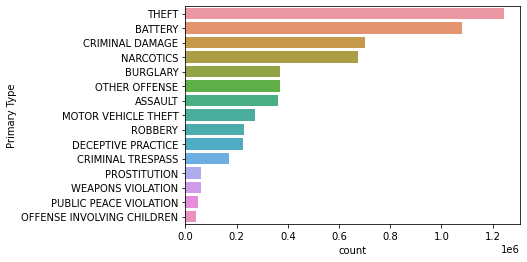

In [79]:
sns.countplot(data= chicago_df, y= 'Primary Type', order= my_order)
plt.show()

In [69]:
top_15 = chicago_df['Primary Type'].value_counts().head(15)

In [70]:
top_15.index

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'OTHER OFFENSE', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object')

In [71]:
my_order = top_15.index

### 어디에서 가장 범죄가 많이 발생했는지, 범죄 장소(Location Descripton) 로 비주얼라이징 하시오.

### 데이터를 주기별로 분석해 보자

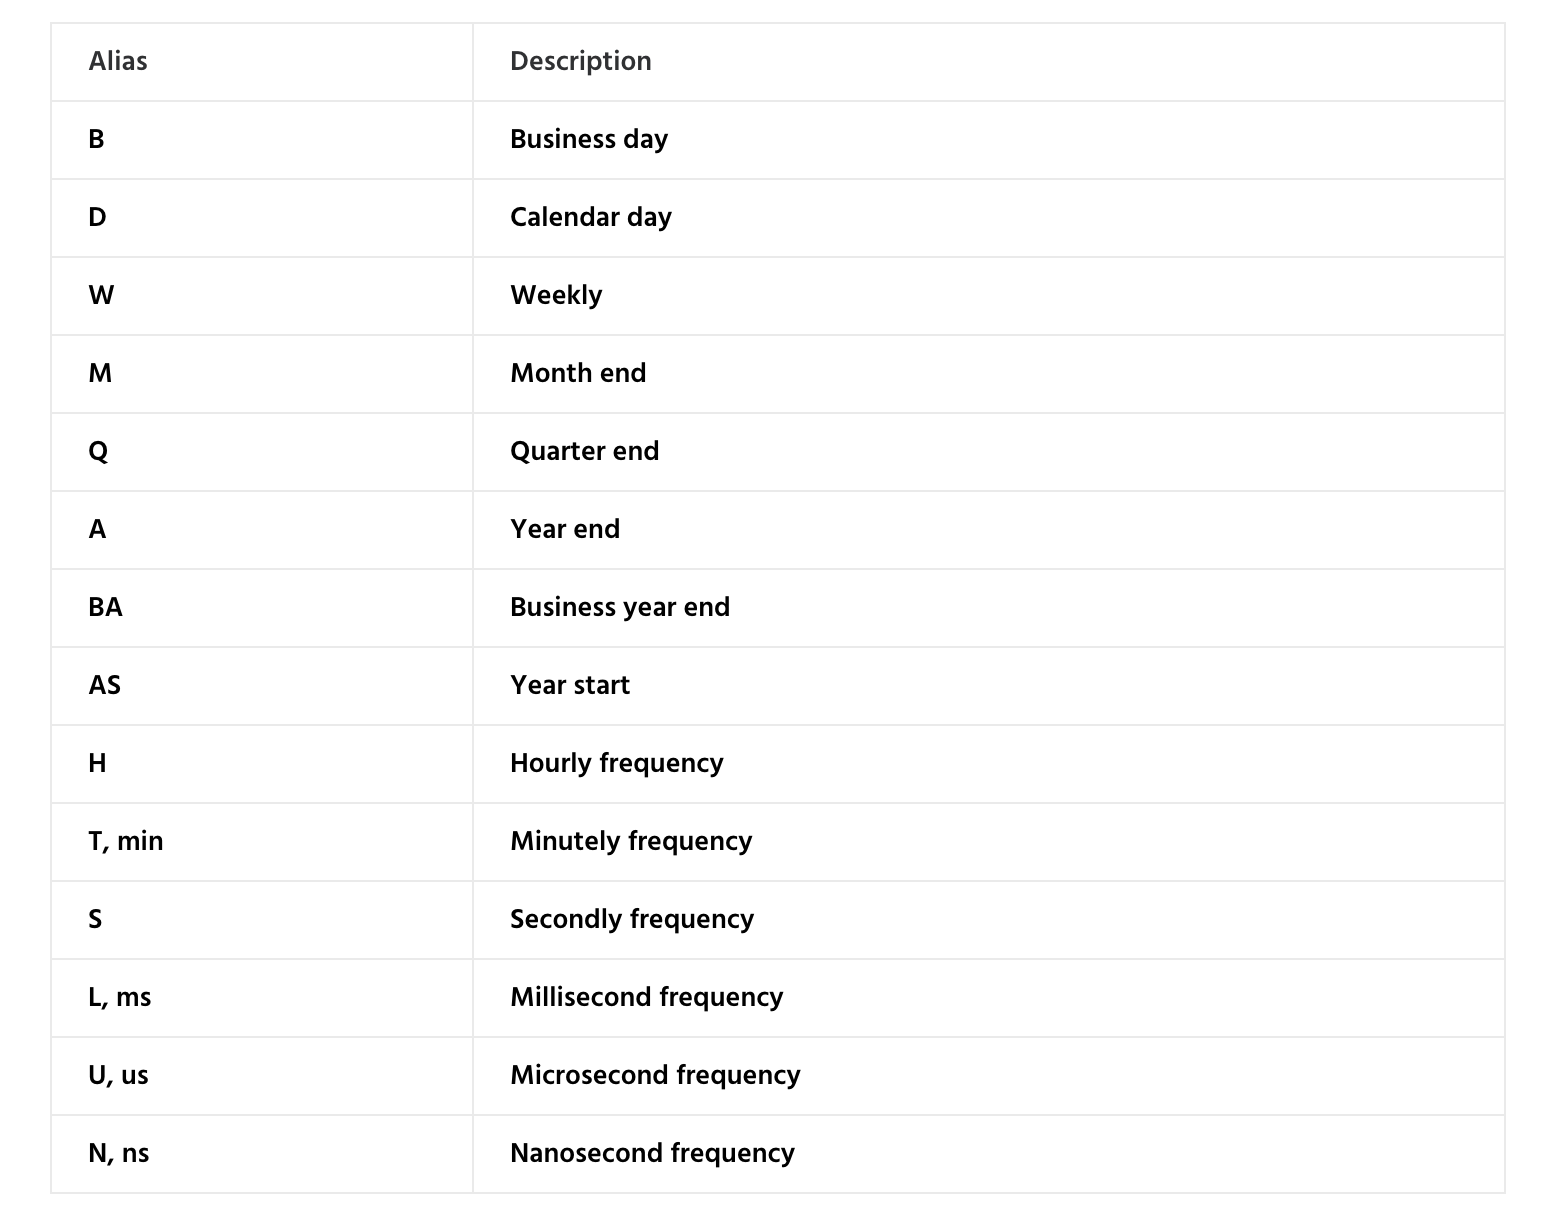

In [82]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday
Date,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6
2006-04-05 18:45:00,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2
2006-02-17 21:03:14,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4
...,...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1
2016-05-03 23:30:00,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,1
2016-05-03 00:15:00,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,1


In [84]:
# resample  'Y' 는 년도다. 년도로 리샘플한 후, 각 년도별 몇개의 범죄 데이터를 가지고 있는지 확인한다.

## resample을 쓸수있는 이유는 인덱스를 날짜로 했기때문에 ##

chicago_df.resample('Y').size()

# 연도에 따라서 총 몇개인지 확인해준다

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

In [85]:
chicago_df.resample('YS').size()

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

In [86]:
df_year = chicago_df.resample('YS').size()

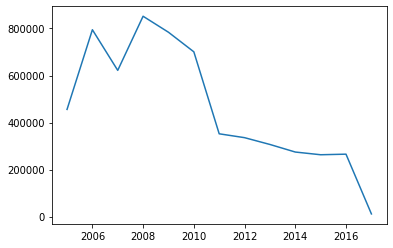

In [87]:
# 위의 데이터를 plot 으로 시각화 한다. 범죄횟수를 눈으로 확인하자.
plt.plot(df_year)
plt.show()

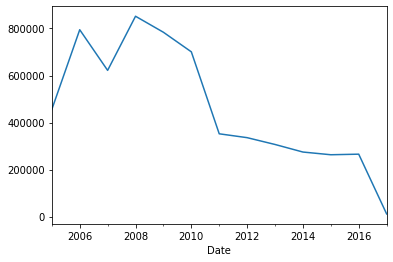

In [89]:
df_year.plot()
plt.show()

In [90]:
# 월별 범죄 발생 건수를 확인하자.
chicago_df.resample('M').size()

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64

In [91]:
df_month = chicago_df.resample('M').size()

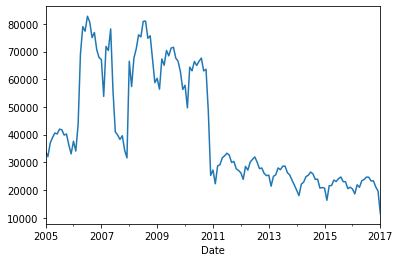

In [92]:
# 월별 범죄 발생 건수도 plot 으로 시각화 하자.
df_month.plot()
plt.show()

#월별로 데이터가 증감이 있었다라고 분석할수 있다

In [93]:
# 분기별 범죄 건수도 확인하자.
chicago_df.resample('Q').size()

Date
2005-03-31    102995
2005-06-30    119769
2005-09-30    123550
2005-12-31    109497
2006-03-31    115389
2006-06-30    225489
2006-09-30    238423
2006-12-31    215383
2007-03-31    192791
2007-06-30    204361
2007-09-30    119086
2007-12-31    105610
2008-03-31    191523
2008-06-30    222331
2008-09-30    236695
2008-12-31    201504
2009-03-31    184055
2009-06-30    203916
2009-09-30    210446
2009-12-31    185483
2010-03-31    171848
2010-06-30    194453
2010-09-30    197116
2010-12-31    137274
2011-03-31     78167
2011-06-30     93064
2011-09-30     95835
2011-12-31     85000
2012-03-31     78574
2012-06-30     88283
2012-09-30     89685
2012-12-31     79128
2013-03-31     71651
2013-06-30     80776
2013-09-30     83510
2013-12-31     70766
2014-03-31     59964
2014-06-30     72991
2014-09-30     76090
2014-12-31     65482
2015-03-31     58503
2015-06-30     68239
2015-09-30     71782
2015-12-31     64471
2016-03-31     60843
2016-06-30     68085
2016-09-30     72500
2016-12-

In [94]:
df_q = chicago_df.resample('Q').size()

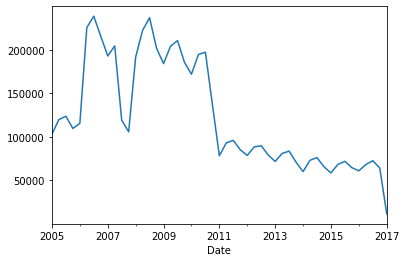

In [96]:
# 분기별 범죄 건수도 시각화 하자.
df_q.plot()
plt.show()

# STEP #3: 데이터 준비

### 월별로(매달 말일) 주기로 하여 데이터프레임을 만들고, 인덱스를 리셋하시오.

In [97]:
chicago_df.resample('M').size()

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64

In [98]:
chicago_prophet =  chicago_df.resample('M').size()

In [104]:
chicago_prophet.reset_index()

,Date,0
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


In [105]:
chicago_prophet = chicago_prophet.reset_index()

### 프로펫 라이브러리를 사용하려면, 날짜 컬럼은 'ds' 로, 에측하려는 수치는 'y'로 바꿔야 합니다(필수).

In [108]:
chicago_prophet.columns = ['ds', 'y']

In [109]:
chicago_prophet

,ds,y
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


# STEP #4: Prophet 으로 예측하기

### [freq 조절 가능한 문자 ](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

[페이스북 프로펫 페이지 예시](https://facebook.github.io/prophet/docs/non-daily_data.html)

In [110]:
prophet = Prophet()

In [111]:
prophet.fit(chicago_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
# 36개월로 해서 예측해보자.

prophet.make_future_dataframe(periods= 36, freq='M')

,ds
0,2005-01-31
1,2005-02-28
2,2005-03-31
3,2005-04-30
4,2005-05-31
...,...
176,2019-09-30
177,2019-10-31
178,2019-11-30
179,2019-12-31


In [113]:
chicago_prophet_future = prophet.make_future_dataframe(periods= 36, freq='M')

In [116]:
prophet.predict(chicago_prophet_future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-31,60463.432502,38673.732392,72574.598782,60463.432502,60463.432502,-4803.616721,-4803.616721,-4803.616721,-4803.616721,-4803.616721,-4803.616721,0.0,0.0,0.0,55659.815781
1,2005-02-28,60332.766196,34005.252219,68803.502145,60332.766196,60332.766196,-9480.730557,-9480.730557,-9480.730557,-9480.730557,-9480.730557,-9480.730557,0.0,0.0,0.0,50852.035639
2,2005-03-31,60188.099929,42852.084043,75148.212433,60188.099929,60188.099929,-1254.934724,-1254.934724,-1254.934724,-1254.934724,-1254.934724,-1254.934724,0.0,0.0,0.0,58933.165205
3,2005-04-30,60048.100316,43353.695838,77628.846541,60048.100316,60048.100316,1114.162021,1114.162021,1114.162021,1114.162021,1114.162021,1114.162021,0.0,0.0,0.0,61162.262337
4,2005-05-31,59903.434049,47842.171477,82961.804478,59903.434049,59903.434049,5396.906083,5396.906083,5396.906083,5396.906083,5396.906083,5396.906083,0.0,0.0,0.0,65300.340133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2019-09-30,1558.148796,-12974.408724,21997.998745,824.614573,2328.577921,1881.254355,1881.254355,1881.254355,1881.254355,1881.254355,1881.254355,0.0,0.0,0.0,3439.403151
177,2019-10-31,1144.976555,-12466.037799,21423.843084,369.701658,1955.573059,2481.402454,2481.402454,2481.402454,2481.402454,2481.402454,2481.402454,0.0,0.0,0.0,3626.379010
178,2019-11-30,745.132451,-17983.015958,15464.782790,-61.677856,1591.108036,-2014.976893,-2014.976893,-2014.976893,-2014.976893,-2014.976893,-2014.976893,0.0,0.0,0.0,-1269.844442
179,2019-12-31,331.960210,-22050.106327,10985.047319,-515.174866,1221.309179,-6015.724385,-6015.724385,-6015.724385,-6015.724385,-6015.724385,-6015.724385,0.0,0.0,0.0,-5683.764174


In [115]:
chicago_pred = prophet.predict(chicago_prophet_future)

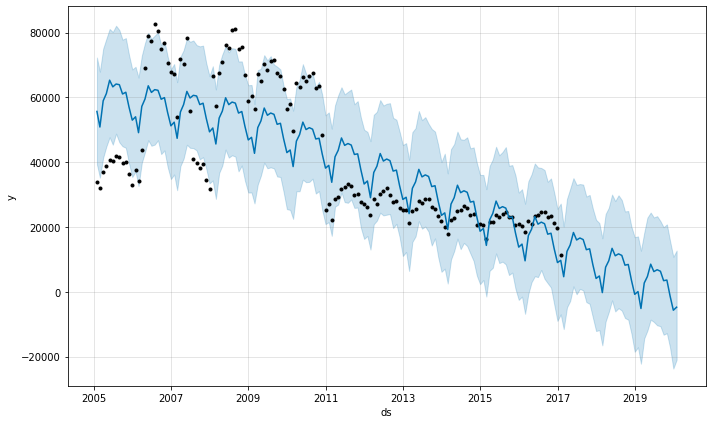

In [119]:
prophet.plot(chicago_pred)
plt.savefig('data_1.jpg')

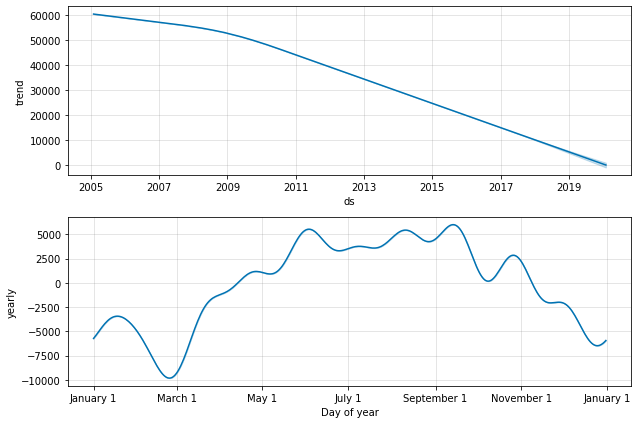

In [121]:
prophet.plot_components(chicago_pred)
plt.savefig('data2.jpg')